In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

EMBED_DIM = 2
BATCH_SIZE = 4
EPOCHS = 1000
IN_CHANNELS = 2
OUT_CHANNELS = IN_CHANNELS
LEARNING_RATE = 0.00001
T = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Imported')
print('Used device:', device)

Imported
Used device: cuda


### Data preprocessing

In [2]:
class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, *data):
        self.data = data

    def __len__(self):
        return self.data[-1].__len__()

    def __getitem__(self, index):
        return [d[index] for d in self.data]
    
# loading dataset
data = np.load('./data/brats_3d_dataset.npy')
flair, t1ce, mask = data[:, 0, None, ...], data[:, 1, None, ...], data[:, 2, None, ...]

# normalizing the data
n_max_flair = [flair[i].max() for i in range(flair.shape[0])]
n_max_t1ce = [t1ce[i].max() for i in range(t1ce.shape[0])]

for idx in range(0, flair.shape[0]):
    flair[idx] = (flair[idx] / n_max_flair[idx]).astype(np.float32)
    t1ce[idx] = (t1ce[idx] / n_max_t1ce[idx]).astype(np.float32)

# going from 0, 1 to -1, 1
flair = flair * 2 - 1
t1ce = t1ce * 2 - 1

flair = flair.transpose(0, 4, 1, 2, 3)
t1ce = t1ce.transpose(0, 4, 1, 2, 3)

print('Data shape: {}'.format(flair.shape))
print('Max: {}'.format(flair.max()))
print('Min: {}'.format(flair.min()))
print('Data loaded')

Data shape: (500, 64, 1, 128, 128)
Max: 1.0
Min: -1.0179553423076868
Data loaded


### Sampling latent spaces

In [3]:
from models.vector_quantized_autoencoder import VQAutoencoder

ae = VQAutoencoder(
    IN_CHANNELS,
    OUT_CHANNELS, 
    n_embed=8192, 
    embed_dim=2, 
    z_channels=2, 
    z_double=False,
    pemb_dim=128,
    num_channels=128,
    channels_mult=[1, 2, 4],
    num_res_blocks=2
).to(device)

ckpt = torch.load('weights/ae_120.pth')
ae.load_state_dict(ckpt['model_state_dict'])
print('model weights loaded ...')

model weights loaded ...


In [4]:
dataset = IdentityDataset(flair, t1ce)
latents = torch.zeros((dataset.__len__(), flair.shape[1], 2 * EMBED_DIM, 32, 32))

def decode_pre_quantization(z, pos):
    assert z.shape[0] == pos.shape[0], 'z and pos must have the same batch size'
    pemb = ae.positional_encoder(pos)
    z_q, _, _ = ae.quantizer(z)
    x = ae.decode(z_q, pemb)
    return x

ae.eval()
for idx, (f, t) in enumerate(tqdm(dataset, position=0, leave=True)):
    input = np.concatenate([f, t], axis=1)
    input = torch.from_numpy(input).to(device, dtype=torch.float32)
    with torch.no_grad():
        pos = torch.arange(0, 64, device=device).long()
        pemb = ae.positional_encoder(pos)
        z, _ = ae.encode_pre_quantization(input, pemb)
    latents[idx] = z.to('cpu')

## preparing the data for training
latents = latents.reshape(-1, 4, 256, 256) # can be seen as rgb image
train_loader = torch.utils.data.DataLoader(latents, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

print('Latents shape: {}'.format(latents.shape))
print('Train dataset length: {}'.format(latents.__len__()))
print('Data prepared')

100%|██████████| 500/500 [03:38<00:00,  2.29it/s]

Latents shape: torch.Size([500, 4, 256, 256])
Train dataset length: 500
Data prepared


### Training the latent diffusion model

ResUNet has 58.56 M params.


Epoch: 2/1000 | Loss: 0.4421: 100%|██████████| 125/125 [02:29<00:00,  1.20s/it]
Epoch: 1/1000 | Loss: 0.8188: 100%|██████████| 125/125 [00:47<00:00,  2.64it/s]
Epoch: 2/1000 | Loss: 0.4487: 100%|██████████| 125/125 [00:47<00:00,  2.63it/s]
Epoch: 3/1000 | Loss: 0.3292: 100%|██████████| 125/125 [00:47<00:00,  2.62it/s]
Epoch: 4/1000 | Loss: 0.2695: 100%|██████████| 125/125 [00:47<00:00,  2.62it/s]
Epoch: 5/1000 | Loss: 0.2829: 100%|██████████| 125/125 [00:47<00:00,  2.61it/s]
Epoch: 6/1000 | Loss: 0.2613: 100%|██████████| 125/125 [00:47<00:00,  2.61it/s]
Epoch: 7/1000 | Loss: 0.2473: 100%|██████████| 125/125 [00:47<00:00,  2.62it/s]
Epoch: 8/1000 | Loss: 0.2520: 100%|██████████| 125/125 [00:47<00:00,  2.65it/s]
Epoch: 9/1000 | Loss: 0.2485: 100%|██████████| 125/125 [00:46<00:00,  2.66it/s]
Epoch: 10/1000 | Loss: 0.2357: 100%|██████████| 125/125 [00:47<00:00,  2.66it/s]
Epoch: 11/1000 | Loss: 0.2413: 100%|██████████| 125/125 [00:46<00:00,  2.66it/s]
Epoch: 12/1000 | Loss: 0.2310: 100%|██

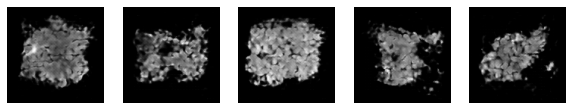

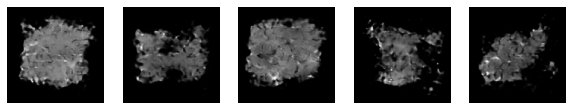

Epoch: 20/1000 | Loss: 0.2221: 100%|██████████| 125/125 [03:20<00:00,  1.61s/it]
Epoch: 21/1000 | Loss: 0.2156: 100%|██████████| 125/125 [00:47<00:00,  2.62it/s]
Epoch: 22/1000 | Loss: 0.2000: 100%|██████████| 125/125 [00:47<00:00,  2.63it/s]
Epoch: 23/1000 | Loss: 0.2193: 100%|██████████| 125/125 [00:47<00:00,  2.63it/s]
Epoch: 24/1000 | Loss: 0.2055: 100%|██████████| 125/125 [00:46<00:00,  2.67it/s]
Epoch: 25/1000 | Loss: 0.2062: 100%|██████████| 125/125 [00:47<00:00,  2.61it/s]
Epoch: 26/1000 | Loss: 0.2128: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
Epoch: 27/1000 | Loss: 0.2115: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
Epoch: 28/1000 | Loss: 0.2092: 100%|██████████| 125/125 [00:45<00:00,  2.77it/s]
Epoch: 29/1000 | Loss: 0.1999: 100%|██████████| 125/125 [00:46<00:00,  2.68it/s]
Epoch: 30/1000 | Loss: 0.1963: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
Epoch: 31/1000 | Loss: 0.2009: 100%|██████████| 125/125 [00:46<00:00,  2.69it/s]
Epoch: 32/1000 | Loss: 0.199

In [6]:
from models.unet import ResUNet
from models.diffusion import DiffusionModule

AMP = False
accumulation_steps = 1
torch.backends.cudnn.benchmark = True

model = ResUNet(in_channels=latents.shape[1], out_channels=latents.shape[1], T=T).to(device)
# model = torch.compile(model)

def count_params(model, verbose=False):
    total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print(f"{model.__class__.__name__} has {total_params * 1.e-6:.2f} M params.")
    return total_params

count_params(model, verbose=True)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=train_loader.__len__() * EPOCHS, eta_min=1e-9, last_epoch=-1
)

scaler = torch.cuda.amp.GradScaler(enabled=AMP)
diffusion = DiffusionModule(T=T, beta_schedule='cosine')
total_loss_history = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    accumulated_loss = []

    progress = tqdm(train_loader, position=0, leave=True)
    for idx, z_q in enumerate(train_loader):
        B = z_q.shape[0]
        z_q = z_q.to(device, dtype=torch.float32, non_blocking=True)

        # sample at random timesteps
        times = torch.randint(low=0, high=T, size=(B,), dtype=torch.long, device=device)

        with torch.autocast(device.type, enabled=AMP):
            # sample noisy images
            x_t, noise = diffusion.forward_process(z_q, times)
            x_t = x_t.to(device, dtype=torch.float32)

            # forward pass
            x_t_pred = diffusion.reverse_process(model, x_t, times)
            loss = F.mse_loss(x_t_pred, noise)


        scaler.scale(loss).backward()
        if (idx + 1) % accumulation_steps == 0 or (idx + 1) == len(train_loader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

            accumulated_loss.append(loss.item())

            with torch.no_grad():
                progress.update(accumulation_steps)
                progress.set_description(f"Epoch: {epoch + 1}/{EPOCHS} | Loss: {np.mean(accumulated_loss):.4f}")

    total_loss_history.append(np.mean(accumulated_loss))

    n_sample = 5
    if (epoch + 1) % 20 == 0:
        model.eval()
        with torch.no_grad():
            g = diffusion.sample(model=model, x_T=torch.randn(n_sample, 4, 256, 256).to(device))
            g = g.view(n_sample, -1, 2 * EMBED_DIM, 32, 32)
            pos = torch.randint(low=0, high=g.shape[1], size=(n_sample,), dtype=torch.long, device=device)
            g = g[torch.arange(n_sample), pos]
            reconstructed = torch.tanh(decode_pre_quantization(g, pos))

        for c in range(IN_CHANNELS):
            plt.figure(figsize=(10, 2))
            for i in range(n_sample):
                plt.subplot(1, n_sample, i + 1)
                plt.imshow(reconstructed[i, c].cpu().numpy(), cmap='gray')
                plt.axis('off')
            plt.show()


In [134]:
# sampling a 3D model and displaying it using IpyWidgets
from ipywidgets import interact

model.eval()
ae.eval()
with torch.no_grad():
    g = diffusion.sample(model=model, x_T=torch.randn(1, 3, 128, 128).to(device))
    g = g.view(-1, EMBED_DIM, 16, 16)
    reconstructed = torch.tanh(ae.decode(g))

def plot_slice(idx, modality):
    m = 0 if modality == 'flair' else 1
    plt.figure(figsize=(5, 5))
    plt.imshow(reconstructed[idx, m].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

interact(plot_slice, idx=(0, reconstructed.shape[0] - 1), modality=['flair', 't1ce'])


Sampling: 100%|██████████| 1000/1000 [00:17<00:00, 56.13it/s]


interactive(children=(IntSlider(value=31, description='idx', max=63), Dropdown(description='modality', options…

<function __main__.plot_slice(idx, modality)>